### Install package/Get into correct directory

In [1]:
# %cd "C:\Users\rockr\Desktop\Code\SRP\SRP Code"
# !git clone https://github.com/openai/glide-text2im.git
# %pip install -q -e .
%cd "C:\Users\rockr\Desktop\Code\SRP\SRP-Code\glide-text2im"

C:\Users\rockr\Desktop\Code\SRP\SRP-Code\glide-text2im


### Set-up functions, models and options

In [2]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [3]:
### Set up sentence split function
import re
alphabets = "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"


def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n", " ")
    text = re.sub(prefixes, "\\1<prd>", text)
    text = re.sub(websites, "<prd>\\1", text)
    if "Ph.D" in text:
        text = text.replace("Ph.D.", "Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] ", " \\1<prd> ", text)
    text = re.sub(acronyms+" "+starters, "\\1<stop> \\2", text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" +
                  alphabets + "[.]", "\\1<prd>\\2<prd>\\3<prd>", text)
    text = re.sub(alphabets + "[.]" + alphabets +
                  "[.]", "\\1<prd>\\2<prd>", text)
    text = re.sub(" "+suffixes+"[.] "+starters, " \\1<stop> \\2", text)
    text = re.sub(" "+suffixes+"[.]", " \\1<prd>", text)
    text = re.sub(" " + alphabets + "[.]", " \\1<prd>", text)
    if "”" in text:
        text = text.replace(".”", "”.")
    if "\"" in text:
        text = text.replace(".\"", "\".")
    if "!" in text:
        text = text.replace("!\"", "\"!")
    if "?" in text:
        text = text.replace("?\"", "\"?")
    text = text.replace(".", ".<stop>")
    text = text.replace("?", "?<stop>")
    text = text.replace("!", "!<stop>")
    text = text.replace("<prd>", ".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [4]:
### Pick which device to use for rendering

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [7]:
### Create base model
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [8]:
### Create upsampler model
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [9]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

### Determine if user wants audio or text input

In [18]:
import os
from scipy.io.wavfile import read as read_wav
from google.cloud import storage, speech

type = input("Would you like to use Text (T) or Speech (S) input?")
if(type == "T" or type == "t"):
    text = input("Please input the text:")
    sentences = split_into_sentences(text)
else:
    found_file = False
    file_path = input(
        "Enter the path to an audio file. Take note that speech to text works best if each sentence is clearly separated. Also be aware that this program cannot generate images of people. You must input a .wav file:")
    while(found_file == False):
        found_file = os.path.exists(file_path) and file_path[-3:] == "wav"
        if(found_file == False):
            file_path = input("That file-path was invalid, Please try again:")
    print("File was succesfully input!")
    sampling_rate, data = read_wav(file_path)
    print("The sampling rate of the file is: {} Hz.".format(sampling_rate))
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\rockr\Desktop\Code\SRP\sample-key.json"
    def upload_blob(bucket_name, source_file_name, destination_blob_name):
        {
            # Uploads a file to the bucket.

            # The ID of your GCS bucket
            # bucket_name = "your-bucket-name"

            # The path to your file to upload
            # source_file_name = "local/path/to/file"
            
            # The ID of your GCS object
            # destination_blob_name = "storage-object-name"
        }
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)

        blob.upload_from_filename(source_file_name)
        {
            # print(
            #     "File {} uploaded to {}.".format(
            #         source_file_name, destination_blob_name
            #     )
            # )
        }
        print("File was successfully uploaded to Google Cloud Storage!")
    upload_blob("srp_speech_to_text", file_path, "audio_file_for_transcription.wav")

    # Instantiates a client
    client = speech.SpeechClient()

    # The name of the audio file to transcribe
    gcs_uri = "gs://srp_speech_to_text/audio_file_for_transcription.wav"

    audio = speech.RecognitionAudio(uri=gcs_uri)

    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=sampling_rate,
        language_code="en-US",
    )

    # Detects speech in the audio file
    response = client.recognize(config=config, audio=audio)

    sentences = []
    for result in response.results:
        s = (format(result.alternatives[0].transcript))
        if(s[0] == ' '):
            s = s[:0] + s[1:]
        print(u"Transcript: {}".format(s))
        sentences.append(s)
        # print("Confidence: {}%".format(int(100*result.alternatives[0].confidence)))
        # correct = input("Is this transcription correct? (Y/N)")
        # if correct != "Y":
        #     s = input("Please enter the correct sentence:")
        # sentences.append(s)

File was succesfully input!
The sampling rate of the file is: 8000 Hz.
File was successfully uploaded to Google Cloud Storage!
Transcript: who is the low to your left shoulder
Transcript: take the winding path to reach the lake
Transcript: not close to the size of the gas tank
Transcript: what degrees off of 35th
Transcript: men the coat before you go out
Transcript: the versus daddy stranded hung limp
Transcript: the stray cat gave birth to kittens
Transcript: the young girl gave no clear response
Transcript: the mill worker before the bell rings
Transcript: what Joy there is in living


100%|██████████| 100/100 [14:37<00:00,  8.77s/it]


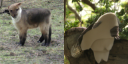

100%|██████████| 27/27 [08:03<00:00, 17.89s/it]


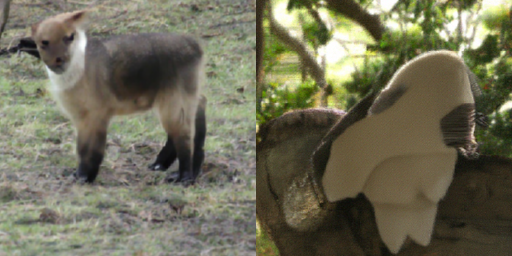

100%|██████████| 100/100 [14:40<00:00,  8.81s/it]


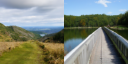

100%|██████████| 27/27 [09:16<00:00, 20.60s/it]


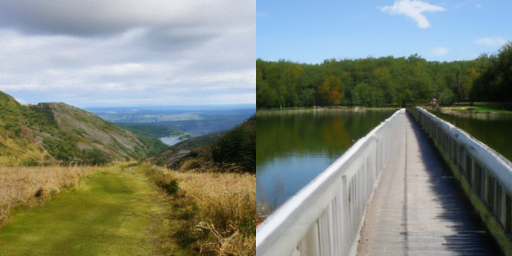

 16%|█▌        | 16/100 [02:27<12:56,  9.24s/it]


KeyboardInterrupt: 

In [19]:
# Low resolution samples (64x64)

for sentence in sentences:
    human = "man" in sentence or "woman" in sentence or "person" in sentence or "people" in sentence or "human" in sentence
    if human == True:
        print("Sorry, this program cannot create images of people")
    else:
        prompt = sentence
        # Sampling parameters
        batch_size =  2
        guidance_scale = 3.0

        # Tune this parameter to control the sharpness of 256x256 images.
        # A value of 1.0 is sharper, but sometimes results in grainy artifacts.
        upsample_temp = 1.0

        # Create the text tokens to feed to the model.
        tokens = model.tokenizer.encode(prompt)
        tokens, mask = model.tokenizer.padded_tokens_and_mask(
            tokens, options['text_ctx']
        )

        # Create the classifier-free guidance tokens (empty)
        full_batch_size = batch_size * 2
        uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
            [], options['text_ctx']
        )

        # Pack the tokens together into model kwargs.
        model_kwargs = dict(
            tokens=th.tensor(
                [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
            ),
            mask=th.tensor(
                [mask] * batch_size + [uncond_mask] * batch_size,
                dtype=th.bool,
                device=device,
            ),
        )

        # Create a classifier-free guidance sampling function
        def model_fn(x_t, ts, **kwargs):
            half = x_t[: len(x_t) // 2]
            combined = th.cat([half, half], dim=0)
            model_out = model(combined, ts, **kwargs)
            eps, rest = model_out[:, :3], model_out[:, 3:]
            cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
            half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
            eps = th.cat([half_eps, half_eps], dim=0)
            return th.cat([eps, rest], dim=1)

        # Sample from the base model.
        model.del_cache()
        samples = diffusion.p_sample_loop(
            model_fn,
            (full_batch_size, 3, options["image_size"], options["image_size"]),
            device=device,
            clip_denoised= True,
            progress= True,
            model_kwargs=model_kwargs,
            cond_fn= None,
        )[:batch_size]
        model.del_cache()

        show_images(samples)

        tokens = model_up.tokenizer.encode(prompt)
        tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
            tokens, options_up['text_ctx']
        )

        # Create the model conditioning dict.
        model_kwargs = dict(
            # Low-res image to upsample.
            low_res=((samples+1)*127.5).round()/127.5 - 1,

            # Text tokens
            tokens=th.tensor(
                [tokens] * batch_size, device=device
            ),
            mask=th.tensor(
                [mask] * batch_size,
                dtype=th.bool,
                device=device,
            ),
        )

        # Sample from the base model.
        model_up.del_cache()
        up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
        up_samples = diffusion_up.ddim_sample_loop(
            model_up,
            up_shape,
            noise=th.randn(up_shape, device=device) * upsample_temp,
            device=device,
            clip_denoised=True,
            progress=True,
            model_kwargs=model_kwargs,
            cond_fn=None,
        )[:batch_size]
        model_up.del_cache()

        show_images(up_samples)

In [ ]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise = th.randn(up_shape, device=device) * upsample_temp,
    device = device,
    clip_denoised = True,
    progress = True,
    model_kwargs = model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()


show_images(up_samples)

  0%|          | 0/27 [00:20<?, ?it/s]


KeyboardInterrupt: 